In [1]:
"""
Modified LSTM to work on a bigger multiclass extract and tuned it a bit.

This is the final LSTM model we ended up using.

Author: Wesley
"""
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import io # StringIO
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Conv1D, Conv2D, GlobalMaxPooling2D,GlobalMaxPooling1D, MaxPool1D, MaxPool2D
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import tensorflow_addons as tfa

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import classification_report

In [2]:
binary_train = pd.read_csv("binary_train.csv")
binary_test = pd.read_csv("binary_test.csv")

In [3]:
# Encode attack labels to int and save as array to be used later.

binary_train[' Label'] = binary_train[' Label'].apply(lambda l : 0 if l == 'BENIGN' else 1)
binary_test[' Label'] = binary_test[' Label'].apply(lambda l : 0 if l == 'BENIGN' else 1)

binary_labels = ["BENIGN", "ATTACK"]

In [4]:
y_train = binary_train[" Label"].copy()
X_train = binary_train.drop([" Label"], axis=1)

y_test = binary_test[" Label"].copy()
X_test = binary_test.drop([" Label"], axis=1)

In [5]:
scal = StandardScaler()
scal = scal.fit(X_train)
X_test = scal.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, stratify=y_train, random_state=42)
X_train = scal.fit_transform(X_train)
X_val = scal.transform(X_val)

In [6]:
n_feat = 80
X_tr = np.reshape(X_train, (len(X_train), n_feat, 1))
X_vl = np.reshape(X_val, (len(X_val), n_feat, 1))
X_tst = np.reshape(X_test, (len(X_test), n_feat, 1))

In [7]:
print(X_tr.shape)
print(y_train.shape)

(129839, 80, 1)
(129839,)


In [19]:
model = keras.Sequential()
model.add(Conv1D(filters = 512, kernel_size = 3, activation='relu', input_shape=X_tr.shape[1:3]))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#opt = keras.optimizers.Adadelta(learning_rate=0.1)
opt = tfa.optimizers.AdaBelief(learning_rate=0.001)
#opt = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay = 5e-3)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001)
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 78, 512)           2048      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 39, 512)          0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 19968)             0         
                                                                 
 dense_30 (Dense)            (None, 512)               10224128  
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                      

In [20]:
history=model.fit(X_tr, y_train.to_numpy(), validation_data = (X_vl, y_val.to_numpy()), batch_size=512, epochs=100, callbacks = [reduce_lr,model_checkpoint_callback])

Epoch 1/100
254/254 [==============================] - 11s 37ms/step - loss: 0.0881 - binary_accuracy: 0.9779 - val_loss: 0.0236 - val_binary_accuracy: 0.9949 - lr: 0.0010
Epoch 2/100
254/254 [==============================] - 9s 35ms/step - loss: 0.0261 - binary_accuracy: 0.9934 - val_loss: 0.0280 - val_binary_accuracy: 0.9948 - lr: 0.0010
Epoch 3/100
254/254 [==============================] - 9s 37ms/step - loss: 0.0236 - binary_accuracy: 0.9937 - val_loss: 0.0210 - val_binary_accuracy: 0.9946 - lr: 0.0010
Epoch 4/100
254/254 [==============================] - 9s 37ms/step - loss: 0.0218 - binary_accuracy: 0.9941 - val_loss: 0.0168 - val_binary_accuracy: 0.9953 - lr: 0.0010
Epoch 5/100
254/254 [==============================] - 9s 36ms/step - loss: 0.0191 - binary_accuracy: 0.9943 - val_loss: 0.0175 - val_binary_accuracy: 0.9947 - lr: 0.0010
Epoch 6/100
254/254 [==============================] - 9s 36ms/step - loss: 0.0187 - binary_accuracy: 0.9943 - val_loss: 0.0188 - val_binary_acc

In [21]:
#history=model.fit(X_tr, y_train.to_numpy(), batch_size=len(X_tr), epochs=10)
path_new_model = "CNN_binary_final.h5"

#Save final model
model.save(path_new_model)

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy', 'lr'])


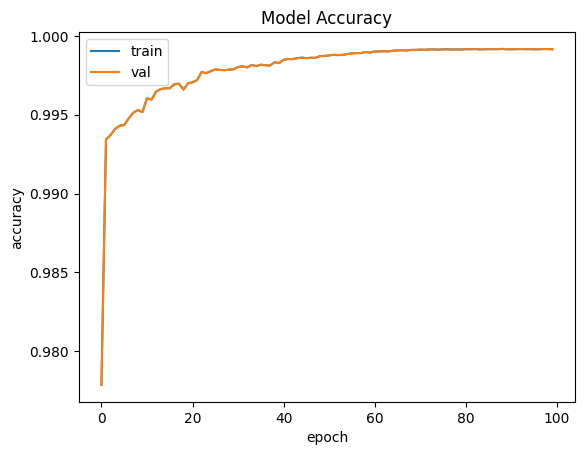

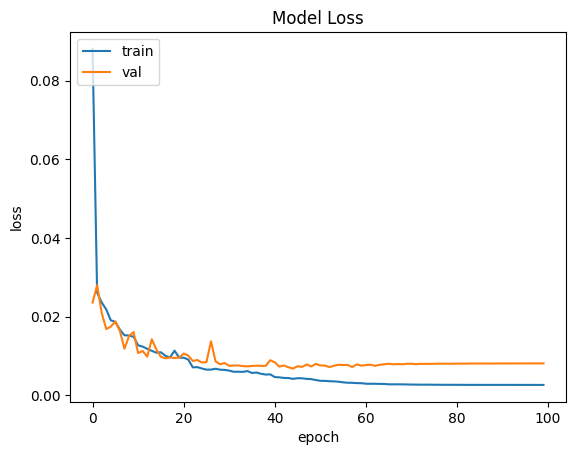

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
#Test predictions
#model.load_weights(checkpoint_filepath)
prediction = model.predict(X_tst)

1160/1160 [==============================] - 4s 3ms/step


In [29]:
pred = [1 if prediction[i] >= 0.5 else 0 for i in range(len(prediction))]
#pred = [np.argmax(x) for x in prediction]
pd.Series(pred).value_counts()

0    18577
1    18521
dtype: int64

In [30]:
print(classification_report(y_test.to_numpy(), pred, digits=6,target_names=binary_labels))

              precision    recall  f1-score   support

      BENIGN   0.997901  0.999461  0.998680     18548
      ATTACK   0.999460  0.997898  0.998678     18550

    accuracy                       0.998679     37098
   macro avg   0.998680  0.998679  0.998679     37098
weighted avg   0.998680  0.998679  0.998679     37098



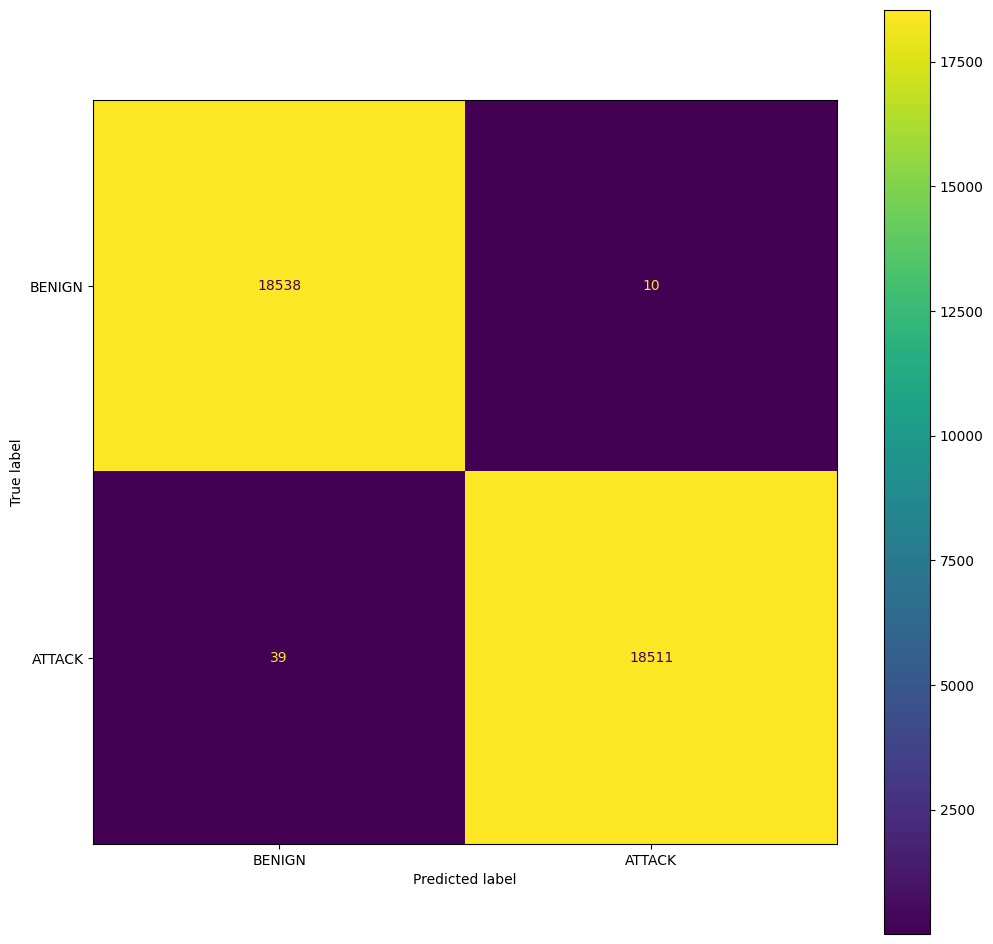

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
plt.savefig("confusion_binary_cnn.png")